<a href="https://colab.research.google.com/github/amenimtibaa/0-Shot-Learning/blob/master/Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# useful imports

In [1]:
%tensorflow_version 1.x
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import random
from PIL import Image
from keras.optimizers import RMSprop
import tensorflow as tf
from keras import backend as K
from keras import layers
from keras import models
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
!sudo pip install h5py

In [3]:
#To make sure that we use GPU 
tf.test.gpu_device_name()
#output should be : '/device:GPU:0'

'/device:GPU:0'

# Necessary functions

## Split data into train, validation and test sets

In [0]:
def load_cifar():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  
  data=np.concatenate((x_train, x_test),axis=0)
  labels=np.concatenate((y_train, y_test),axis=0)

  # summarize loaded dataset
  print('data=%s, labels=%s' % (data.shape, labels.shape))

  #train data : from 0 to 4
  train_digit_indices = [np.where(labels == i)[0] for i in range(5)]
  data_train = np.concatenate((np.copy(data[train_digit_indices[0],]) , 
                np.copy(data[train_digit_indices[1],]), 
                np.copy(data[train_digit_indices[2],]),
                np.copy(data[train_digit_indices[3],]),
                np.copy(data[train_digit_indices[4],])    
                ), axis=0)
  labels_train = np.concatenate((
      np.full((train_digit_indices[0].shape[0], 1), 0, dtype=int),
      np.full((train_digit_indices[1].shape[0], 1), 1, dtype=int),
      np.full((train_digit_indices[2].shape[0], 1), 2, dtype=int),
      np.full((train_digit_indices[3].shape[0], 1), 3, dtype=int),
      np.full((train_digit_indices[4].shape[0], 1), 4, dtype=int)
  ), axis=0)

  #test data : from 5 to 9
  test_digit_indices = [np.where(labels == i)[0] for i in range(5,10)]
  data_test = np.concatenate((np.copy(data[test_digit_indices[0],]) , 
                np.copy(data[test_digit_indices[1],]), 
                np.copy(data[test_digit_indices[2],]),
                np.copy(data[test_digit_indices[3],]),
                np.copy(data[test_digit_indices[4],])    
                ), axis=0)
  labels_test = np.concatenate((
      np.full((test_digit_indices[0].shape[0], 1), 5, dtype=int),
      np.full((test_digit_indices[1].shape[0], 1), 6, dtype=int),
      np.full((test_digit_indices[2].shape[0], 1), 7, dtype=int),
      np.full((test_digit_indices[3].shape[0], 1), 8, dtype=int),
      np.full((test_digit_indices[4].shape[0], 1), 9, dtype=int)
  ), axis=0)

  #valid data
  data_train, data_cv, labels_train, labels_cv =train_test_split(data_train, labels_train, test_size=0.1, random_state=42)

  #Add a portion of classes from 0 to 4 for test 
  data_train, test, labels_train, labels =train_test_split(data_train, labels_train, test_size=0.1, random_state=42)
  data_test = np.concatenate((
                data_test,
                test   
                ), axis=0)
  labels_test = np.concatenate((
                labels_test,
                labels
                ), axis=0)
  #summarize
  print('data_train=%s, labels_train=%s' % (data_train.shape, labels_train.shape))
  print('data_cv=%s, labels_cv=%s' % (data_cv.shape, labels_cv.shape))
  print('data_test=%s, labels_train=%s' % (data_test.shape, labels_test.shape))
  
  return data_train, data_cv, data_test, labels_train, labels_cv, labels_test

In [0]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [0]:
def plot_data(data):
	# plot first few images
	for i in range(9):
		# define subplot
		plt.subplot(330 + 1 + i)
		# plot raw pixel data
		plt.imshow(data[i])
	# show the figure
	plt.show()

## padd data with borders

In [0]:
def pad(x_train, x_valid, x_test, p=2):
  # Process each sequence on a different GPU
  with tf.device('/gpu:0'):
      x_train = np.pad(x_train, ((0,0), (0,0), (p,p) , (p, p), (0,0)), 'edge')
  with tf.device('/gpu:1'):
      x_valid = np.pad(x_valid, ((0,0), (0,0), (p,p) , (p, p), (0,0)), 'edge')
  with tf.device('/gpu:2'):
      x_test = np.pad(x_test, ((0,0), (0,0), (p,p) , (p, p), (0,0)), 'edge')
  return x_train, x_valid, x_test

In [0]:
def display_image(x_train, position):
    image = x_train[position].squeeze()
    #plt.title('Example %d. Label: %d' % (position, y_train[position]))
    plt.imshow(image)

## create training pairs

In [0]:
def create_pairs(x, digit_indices, num_classes =5):
    pairs = []
    labels = []
    n = (min([len(digit_indices[d]) for d in range(num_classes)])) -10
    for d in range(num_classes):
        for i in range(n):
            with tf.device('/gpu:0'):
              #here we create positive pairs for image d
              z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
              pairs += [[x[z1], x[z2]]]
            with tf.device('/gpu:1'):
              #here we create negative pairs for image d
              dn = random.choice([nb for nb in range(0,num_classes) if nb not in [d]])
              z1, z2 = digit_indices[d][i], digit_indices[dn][i]
              pairs += [[x[z1], x[z2]]]
              labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [0]:
def create_test_pairs(x, digit_indices, num_classes =10):
    pairs = []
    labels = []
    n = (min([len(digit_indices[d]) for d in range(num_classes)]) - 1)  
    for i in range(0,n,2):
      for d in range(num_classes):
        with tf.device('/gpu:0'):
          #here we create positive pairs for image d
          z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
          pairs += [[x[z1], x[z2]]]
          labels += [1]
        for dn in range(num_classes):
          if dn not in {d}:
            with tf.device('/gpu:1'):
              #here we create negative pairs for image d
              z1, z2 = digit_indices[d][i], digit_indices[dn][i]
              pairs += [[x[z1], x[z2]]]
              labels += [0]

    return np.array(pairs), np.array(labels)

## define model loss

In [0]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)



## define model accuracy

In [0]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

## define model output

In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(sum_square)


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)



# Transfer learning

In [14]:
num_classes = 10
x_train, x_valid, x_test, y_train, y_valid, y_test= load_cifar()



170500096/170498071 [==============================] - 6s 0us/step
data=(60000, 32, 32, 3), labels=(60000, 1)
data_train=(24300, 32, 32, 3), labels_train=(24300, 1)
data_cv=(3000, 32, 32, 3), labels_cv=(3000, 1)
data_test=(32700, 32, 32, 3), labels_train=(32700, 1)


In [0]:
# create training+test positive and negative pairs

digit_indices_train = [np.where(y_train == i)[0] for i in range(5)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices_train)

digit_indices_cv = [np.where(y_valid == i)[0] for i in range(5)]
cv_pairs, cv_y = create_pairs(x_valid, digit_indices_cv)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_test_pairs(x_test, digit_indices)


In [16]:
print(tr_pairs.shape,tr_y.shape, cv_pairs.shape, cv_y.shape, te_pairs.shape, te_y.shape)


(48240, 2, 32, 32, 3) (48240,) (5700, 2, 32, 32, 3) (5700,) (26300, 2, 32, 32, 3) (26300,)


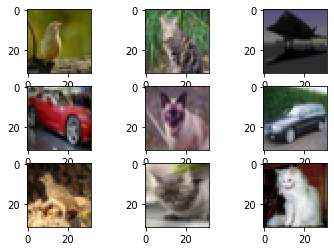

In [17]:
plot_data(x_train)

In [18]:
#padd to get 50*50*3
tr_pairs, cv_pairs, te_pairs = pad(tr_pairs, cv_pairs, te_pairs, 9)
print(tr_pairs.shape)

(48240, 2, 50, 50, 3)


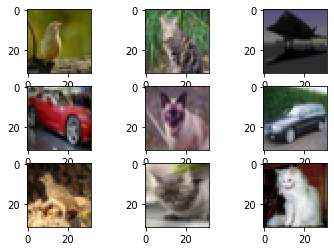

In [19]:
plot_data(x_train)

In [20]:
from keras.applications import ResNet50
K.clear_session()
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
for layer in conv_base.layers:
    layer.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [21]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 25, 25, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [22]:
# Construct the full network
layer = conv_base.output
#add custom layers
layer = layers.Flatten(name='flatten')(layer)
layer = layers.BatchNormalization()(layer)
layer = layers.Dense(128, activation='relu')(layer) 
layer = layers.Dropout(0.5)(layer)
layer = layers.BatchNormalization()(layer)
layer = layers.Dense(64, activation='relu')(layer) 

# creating the final model 
final_model = models.Model(conv_base.input, output=layer)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [0]:
# Define the tensors for the two input images
input_shape=(50, 50, 3)
left_input = layers.Input(input_shape)
right_input = layers.Input(input_shape)

# Generate the encodings (feature vectors) for the two images
encoded_l = final_model(left_input)
encoded_r = final_model(right_input)
prediction = layers.Lambda(euclidean_distance,
              output_shape=eucl_dist_output_shape)([encoded_l, encoded_r]) 

# Connect the inputs with the outputs
model = models. Model(inputs=[left_input,right_input],outputs=prediction)

In [24]:
from keras.callbacks import ModelCheckpoint
# train
epochs = 7
model.compile(loss=contrastive_loss, optimizer=RMSprop(lr=2e-4), metrics=[accuracy])
checkpointer = ModelCheckpoint(
          filepath='model.hfs5',
          save_best_only=True)
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
                batch_size=20,
                epochs=epochs,  validation_data=([cv_pairs[:, 0], cv_pairs[:, 1]], cv_y), callbacks=[checkpointer])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 48240 samples, validate on 5700 samples
Epoch 1/7
48240/48240 [==============================] - 215s 4ms/step - loss: 4.2672 - accuracy: 0.5021 - val_loss: 0.3986 - val_accuracy: 0.5000
Epoch 2/7
48240/48240 [==============================] - 206s 4ms/step - loss: 0.3006 - accuracy: 0.5136 - val_loss: 0.3529 - val_accuracy: 0.5016
Epoch 3/7
48240/48240 [==============================] - 206s 4ms/step - loss: 0.2817 - accuracy: 0.5432 - val_loss: 0.3111 - val_accuracy: 0.5109
Epoch 4/7
48240/48240 [==============================] - 205s 4ms/step - loss: 0.2601 - accuracy: 0.5830 - val_loss: 0.2729 - val_accuracy: 0.5604
Epoch 5/7
48240/48240 [==============================] - 204s 4ms/step - loss: 0.2424 - accuracy: 0.6119 - val_loss: 0.2493 - val_accuracy: 0.6032
Epoch 6/7
48240/48240 [==============================] - 205s 4ms/step - loss: 0.2257 - accuracy: 0.6435 - val_loss: 0.

In [0]:
model.save('cifar10.h5')

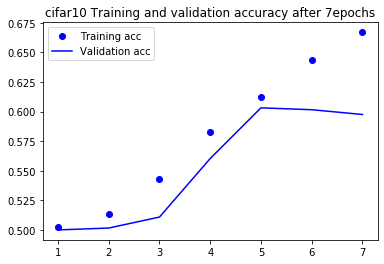

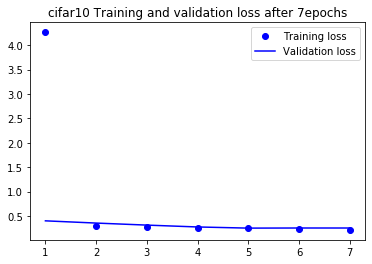

In [26]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('cifar10 Training and validation accuracy after 7epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('cifar10 Training and validation loss after 7epochs')
plt.legend()
plt.show()

In [27]:
score = model.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) 

26300/26300 [==============================] - 71s 3ms/step
Test loss: 0.39221869446025603
Test accuracy: 0.32996197718744497


## print one shot results

In [28]:
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
y_pred.shape

(26300, 1)

### test on known class

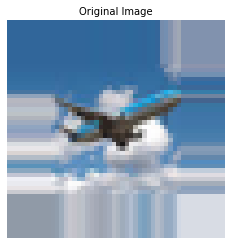

In [29]:
plt.tight_layout()
plt.subplot(1,1,1)
plt.axis('off')
plt.imshow(te_pairs[0, 0])
plt.title('Original Image', fontdict = {'fontsize' : 10})
plt.show()

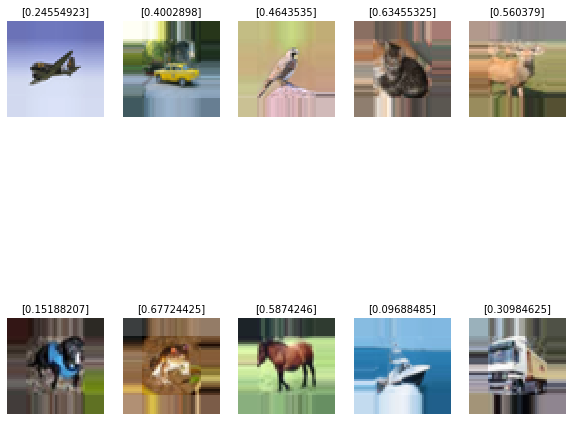

In [30]:
w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img =  tf.keras.preprocessing.image.array_to_img( te_pairs[i-1, 1], data_format=None, scale=True,dtype=None) 
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title( str(y_pred[i-1]), fontdict = {'fontsize' : 10})
plt.show()

## test on unknown class

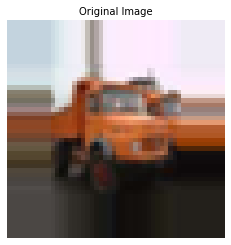

In [31]:
plt.tight_layout()
plt.subplot(1,1,1)
plt.axis('off')
plt.imshow(te_pairs[te_pairs.shape[0]-1, 0])
plt.title('Original Image', fontdict = {'fontsize' : 10})
plt.show()

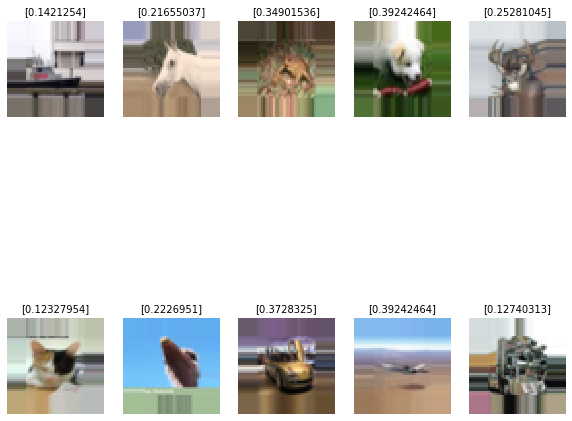

In [32]:
w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img =  tf.keras.preprocessing.image.array_to_img( te_pairs[te_pairs.shape[0]-i, 1], data_format=None, scale=True,dtype=None) 
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title( str(y_pred[te_pairs.shape[0]-i]), fontdict = {'fontsize' : 10})
plt.show()